In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16602218490912308309
]


Epoch 1/50
1637/1637 - 6s - loss: 0.0116
Epoch 2/50
1637/1637 - 2s - loss: 0.0062
Epoch 3/50
1637/1637 - 2s - loss: 0.0061
Epoch 4/50
1637/1637 - 2s - loss: 0.0061
Epoch 5/50
1637/1637 - 2s - loss: 0.0061
Epoch 6/50
1637/1637 - 2s - loss: 0.0061
Epoch 7/50
1637/1637 - 2s - loss: 0.0061
Epoch 8/50
1637/1637 - 2s - loss: 0.0061
Epoch 9/50
1637/1637 - 2s - loss: 0.0061
Epoch 10/50
1637/1637 - 2s - loss: 0.0060
Epoch 11/50
1637/1637 - 2s - loss: 0.0061
Epoch 12/50
1637/1637 - 2s - loss: 0.0061
Epoch 13/50
1637/1637 - 2s - loss: 0.0061
Epoch 14/50
1637/1637 - 2s - loss: 0.0061
Epoch 15/50
1637/1637 - 2s - loss: 0.0060
Epoch 16/50
1637/1637 - 2s - loss: 0.0061
Epoch 17/50
1637/1637 - 2s - loss: 0.0060
Epoch 18/50
1637/1637 - 2s - loss: 0.0060
Epoch 19/50
1637/1637 - 2s - loss: 0.0060
Epoch 20/50
1637/1637 - 2s - loss: 0.0060
Epoch 21/50
1637/1637 - 2s - loss: 0.0061
Epoch 22/50
1637/1637 - 2s - loss: 0.0061
Epoch 23/50
1637/1637 - 2s - loss: 0.0060
Epoch 24/50
1637/1637 - 2s - loss: 0.0060
E

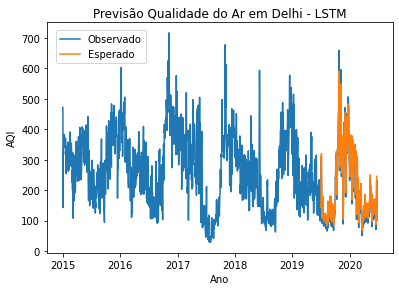

In [36]:
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv(r"C:\Users\nunok\Documents\Msc Data Science\time series\project\delhi_air_quality\city_day.csv", engine='python')
dataframe = dataframe[dataframe["City"] == "Delhi"]
dataframe = dataframe[["AQI"]]
#dataframe.astype(int)
dataframe = dataframe.dropna()
#dataframe = read_csv(r"C:\Users\nunok\Documents\Msc Data Science\time series\project\dataset.csv", usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.82)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])


plt.plot(scaler.inverse_transform(dataset),label = "Observado")
#plt.plot(trainPredictPlot)
plt.plot(testPredictPlot, label = "Esperado")

plt.legend(bbox_to_anchor =(0.3, 0.8), ncol = 1)

ax.set_title('Previsão Qualidade do Ar em Delhi - LSTM')
ax.set_ylabel('AQI')
ax.set_xlabel('Ano')
ax.set_xticks([0,365,730,1095,1460,1825])
ax.set_xticklabels(["2015","2016","2017","2018","2019","2020"])

plt.show()